In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
!python --version

Python 3.13.5


In [3]:
pd.__version__

'2.2.3'

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

print(mlflow.get_experiment_by_name("nyc-taxi-experiment"))

2025/10/18 11:09:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/18 11:09:19 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1760438891994, experiment_id='2', last_update_time=1760438891994, lifecycle_stage='active', name='nyc-taxi-experiment', tags={'mlflow.experimentKind': 'custom_model_development'}>


In [5]:
print(mlflow.get_experiment_by_name("nyc-taxi-experiment"))

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1760438891994, experiment_id='2', last_update_time=1760438891994, lifecycle_stage='active', name='nyc-taxi-experiment', tags={'mlflow.experimentKind': 'custom_model_development'}>


In [6]:
# df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')


In [7]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.dt.total_seconds() / 60

In [8]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [9]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [10]:
df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [11]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts) 
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 221724 stored elements and shape (73908, 507)>

In [12]:
target = 'duration'
y_train = df[target].values 

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
y_pred = lr.predict(X_train)

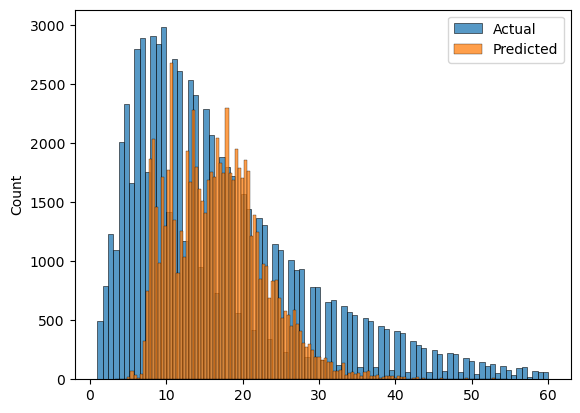

In [15]:
sns.histplot(y_train, label='Actual')
sns.histplot(y_pred, label='Predicted')
plt.legend()

In [16]:
np.sqrt(mean_squared_error(y_train, y_pred))

np.float64(9.838799799829626)

In [17]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [19]:
len(df_train), len(df_val)

(73908, 61921)

In [20]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
categorical = ['PU_DO'] 
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
target = 'duration'
y_train = df_train[target].values 
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

np.sqrt(mean_squared_error(y_train, y_pred))

np.float64(5.699564118198954)

In [24]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [25]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Kristof")
    mlflow.log_param("train-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact('models/lin_reg.bin', artifact_path='models_pickle')


## XGboost

In [26]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [27]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [29]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
    }

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

In [29]:
mlflow.xgboost.autolog(False)

In [ ]:
with mlflow.start_run():
    best_params = {
        'max_depth': 48,
        'learning_rate': 0.1256073328183555,
        'reg_alpha': 0.34485337886791795,
        'reg_lambda': 0.018950580168387268,
        'min_child_weight': 1.492447195778266,
        'objective': 'reg:linear',
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # Log the XGBoost model with signature
    signature = mlflow.models.infer_signature(X_val, y_pred)
    
    mlflow.xgboost.log_model(
        xgb_model=booster, 
        name="MyModel",
        signature=signature
    )


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

# mlflow.sklearn.autolog(
#     log_models=True,
#     log_datasets=True,
#     log_input_examples=True,
#     log_model_signatures=True,
# )

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

TypeError: got an unexpected keyword argument 'squared'